# Part 2: Oblivious Amplitude Amplification (in Qiskit!)

Here, we implement the "oblivious" version of Grover's algorithm. We suppose $|a\rangle$ and $|b\rangle$ are two kets in a possibly large Hilbert space $\mathcal{H}$. We are given access to the unitaries $e^{i\phi}|a\rangle\langle a|$, $e^{i\phi}|b\rangle\langle b|$ for arbitrary $\phi$, as well as a fixed unitary $U$ for which all we know is that $\langle a|U|b\rangle \neq 0$. The aim of the algorithm is to construct, using these resources, a unitary $Q$ such that $|\langle a|Q|b\rangle| \approx 1$.

For our purposes, we consider a system of six qubits where $|a\rangle$ is a superposition of all strings with random nonzero weights, and $|b\rangle$ is the particular string $|111111\rangle$.

### 1. State Preparation
First we begin by preparing our states. We are given that $|a\rangle$ is a superposition of all strings with random nonzero weights, and $|b\rangle$ is the particular string $|111111\rangle$.

In [10]:
from qiskit import QuantumCircuit, Aer, execute
import numpy as np

# Number of qubits
n_qubits = 6

# Define target state |b> = |111111>
qc_b = QuantumCircuit(n_qubits)
for qubit in range(n_qubits):
    qc_b.x(qubit)

# Define superposition state |a>, generate random amplitudes
random_amplitudes = np.random.random(2**n_qubits) + 1j * np.random.random(2**n_qubits)

# Normalize amplitudes
normalized_amplitudes = random_amplitudes / np.linalg.norm(random_amplitudes)

# Initialize state |a> in Qiskit
qc_a = QuantumCircuit(n_qubits)
qc_a.initialize(normalized_amplitudes, range(n_qubits))

# Display circuits
print("Circuit for |b> (|111111>):")
print(qc_b)
print("\nCircuit for |a> (Random superposition):")
print(qc_a)

Circuit for |b> (|111111>):
     ┌───┐
q_0: ┤ X ├
     ├───┤
q_1: ┤ X ├
     ├───┤
q_2: ┤ X ├
     ├───┤
q_3: ┤ X ├
     ├───┤
q_4: ┤ X ├
     ├───┤
q_5: ┤ X ├
     └───┘

Circuit for |a> (Random superposition):
     »
q_0: »
     »
q_1: »
     »
q_2: »
     »
q_3: »
     »
q_4: »
     »
q_5: »
     »
«     ┌──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

### 3. Find Reflection Operators
We define our phase/reflection operators as $A_\phi = e^{i\phi|A_0\rangle\langle A_0|}$, $B_\phi = e^{i\phi|B_0\rangle\langle B_0|}$.

In [11]:
from qiskit.quantum_info import Statevector, Operator
from qiskit import QuantumCircuit

# Define phase parameter
phi = np.pi / 2  # Example phase

# |a> state vector
a_state = Statevector(normalized_amplitudes)

# |b> state vector
b_state = Statevector.from_label('111111')

# Projectors |a><a| and |b><b|
proj_a = np.outer(a_state.data, np.conjugate(a_state.data))
proj_b = np.outer(b_state.data, np.conjugate(b_state.data))

# Reflection matrices
A_phi = np.eye(2**n_qubits) + (np.exp(1j * phi) - 1) * proj_a
B_phi = np.eye(2**n_qubits) + (np.exp(1j * phi) - 1) * proj_b

# Convert to Qiskit operators
A_phi_operator = Operator(A_phi)
B_phi_operator = Operator(B_phi)

# Build circuits to implement unitaries
qc_a_phi = QuantumCircuit(n_qubits)
qc_b_phi = QuantumCircuit(n_qubits)

# Add unitary gates to circuits
qc_a_phi.unitary(A_phi_operator, range(n_qubits), label='A_phi')
qc_b_phi.unitary(B_phi_operator, range(n_qubits), label='B_phi')

# Display circuits
print("Circuit for A_phi:")
print(qc_a_phi)

print("\nCircuit for B_phi:")
print(qc_b_phi)

Circuit for A_phi:
     ┌────────┐
q_0: ┤0       ├
     │        │
q_1: ┤1       ├
     │        │
q_2: ┤2       ├
     │  A_phi │
q_3: ┤3       ├
     │        │
q_4: ┤4       ├
     │        │
q_5: ┤5       ├
     └────────┘

Circuit for B_phi:
     ┌────────┐
q_0: ┤0       ├
     │        │
q_1: ┤1       ├
     │        │
q_2: ┤2       ├
     │  B_phi │
q_3: ┤3       ├
     │        │
q_4: ┤4       ├
     │        │
q_5: ┤5       ├
     └────────┘


### 2. Define U
We now define $U$. Although any $U$ s.t. $\langle a|U|b\rangle \neq 0$ can work, we implement $U = a(|A_0\rangle\langle B_0| - |A_\perp\rangle\langle B_\perp|)  + \sqrt{1 - a^2}(|A_\perp\rangle\langle B_0| + |A_0\rangle\langle B_\perp|)$ to use an approximation $d$ for the number of iterations of $Q$ needed later on.

In [12]:
from qiskit.quantum_info import Operator
import numpy as np

# Nearest Unitary (I'm sorry, I couldn't get it exactly unitary bc of rounding)
def nearest_unitary(matrix):
    # Compute SVD
    U, _, Vh = np.linalg.svd(matrix)
    # Compute nearest unitary
    unitary_matrix = np.dot(U, Vh)
    return unitary_matrix

# Define scalar a
a = 0.6
sqrt_1_minus_a2 = np.sqrt(1 - a**2)

# |a> and |b> as state vectors
a_state = Statevector(normalized_amplitudes)
b_state = Statevector.from_label('111111')

# |A0><A0| and |B0><B0|
proj_a = np.outer(a_state.data, np.conjugate(a_state.data))
proj_b = np.outer(b_state.data, np.conjugate(b_state.data))

# |A_perp> and |B_perp>
proj_a_perp = np.eye(2**n_qubits) - proj_a
proj_b_perp = np.eye(2**n_qubits) - proj_b

# Define U as a matrix
U = (
    a * (np.dot(proj_a, proj_b) - np.dot(proj_a_perp, proj_b_perp))
    + sqrt_1_minus_a2 * (np.dot(proj_a_perp, proj_b) + np.dot(proj_a, proj_b_perp))
)
U = nearest_unitary(U) # This will introduce errors but it's the best we can do

# Convert to Qiskit Operator
U_operator = Operator(U)

# Build circuit to implement U
qc_U = QuantumCircuit(n_qubits)
qc_U.unitary(U_operator, range(n_qubits), label='U')

# Display the circuit
print("Circuit for U:")
print(qc_U)

Circuit for U:
     ┌────┐
q_0: ┤0   ├
     │    │
q_1: ┤1   ├
     │    │
q_2: ┤2   ├
     │  U │
q_3: ┤3   ├
     │    │
q_4: ┤4   ├
     │    │
q_5: ┤5   ├
     └────┘


### 4. Putting it Together
We use the unitaries and reflection operators to create a circuit for $Q$.

Number of iterations: 3


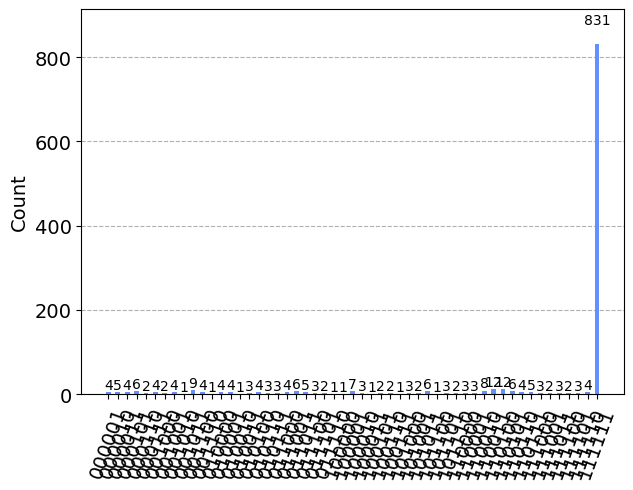

In [13]:
from qiskit.visualization import plot_histogram
from qiskit import Aer, transpile, execute

# Compute Q = B_phi * U * A_phi * U_dagger
U_dagger = U.conj().T
Q = np.dot(B_phi, np.dot(U, np.dot(A_phi, U_dagger)))

# Convert Q to operator
Q_operator = Operator(Q)

# Build quantum circuit
qc = QuantumCircuit(n_qubits)

# Initialize state |a>
qc.initialize(normalized_amplitudes, range(n_qubits))

# Compute number of iterations
d = (int) (np.pi / (2 * np.arcsin(a))) + 1 # Number of iterations
print(f"Number of iterations: {d}")

# Apply Q matrix
for _ in range(d):
    qc.unitary(Q_operator, range(n_qubits), label='Q')

# Simulate circuit
simulator = Aer.get_backend('statevector_simulator')
result = execute(qc, simulator).result()
statevector = result.get_statevector()

# Measure for histogram
qc.measure_all()
simulator = Aer.get_backend('qasm_simulator')
qc = transpile(qc, simulator)
result = execute(qc, simulator, shots=1024).result()
counts = result.get_counts()

# Plot histogram
plot_histogram(counts)


# Part 3: Performance

As seen above, 